# Examining Volunteer internal consistency

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lib.galaxy_utilities as gu
from tqdm import tqdm
from functools import partial
from gzbuilder_analysis.aggregation.spirals.oo import Arm

In [3]:
%run get_duplicate_galaxies.py

In [4]:
duplicates = pd.read_csv('lib/duplicate_galaxies.csv', index_col=0)
ss_ids, validation_ids = duplicates.values.T.astype(int)
dr8ids = duplicates.index.values.astype(int)

In [5]:
print('Defining helper functions')

def get_annotations(sid):
    return gu.classifications.query(
        'subject_ids == {}'.format(sid)
    )['annotations'].apply(json.loads)

def n_drawn_comps(a, task=0):
    try:
        return len(a[task]['value'][0]['value'])
    except IndexError:
        return np.nan

def get_details(ann0, ann1, task=0):
    n_drawn0 = ann0.apply(partial(n_drawn_comps, task=task))
    n_drawn1 = ann1.apply(partial(n_drawn_comps, task=task))
    return sum(((s.mean(), s.std()) for s in (n_drawn0, n_drawn1)), ())

def get_disk_details(ann0, ann1):
    return get_details(ann0, ann1, task=0)

def get_bulge_details(ann0, ann1):
    return get_details(ann0, ann1, task=1)

def get_bar_details(ann0, ann1):
    return get_details(ann0, ann1, task=2)

def get_spiral_arm_details(ann0, ann1):
    return get_details(ann0, ann1, task=3)

Defining helper functions


In [6]:
print('Constructing classification details Data Frame')
out = []
columns = [
    '{}-{}-{}'.format(s, k, v) 
    for k in ('disk', 'bulge', 'bar', 'spiral_arms')
    for s in ('original', 'validation')
    for v in ('mean', 'std')
]
for i in range(len(dr8ids)):
    id_details = {
        'original_id': ss_ids[i],
        'validation_id': validation_ids[i],
        'dr8id': dr8ids[i],
    }
    details = np.array([
        get_details(
            get_annotations(ss_ids[i]),
            get_annotations(validation_ids[i]),
            task=j
        )
        for j in range(4)
    ])
    freq_details = {k: v for k, v in zip(columns, details.reshape(-1))}
    out.append({**id_details, **freq_details})
df = pd.DataFrame(out)

Constructing classification details Data Frame


How in-agreement were our volunteers? These plots show the variance in the percentage of volunteers drawing a component for galaxies in our original and validation subsets. The spiral arm plot shows the mean number of spiral arms for each galaxy.

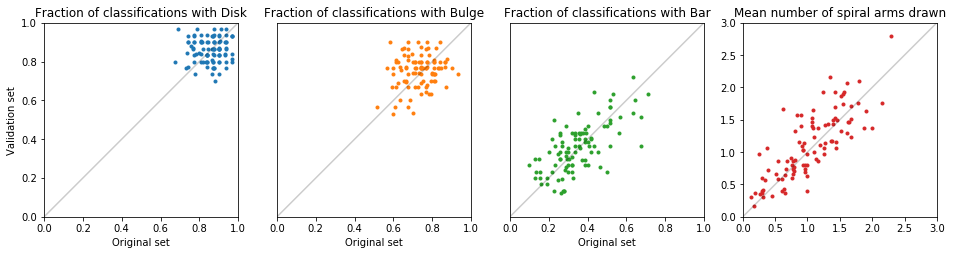

In [7]:
fig, (ax_disk, ax_bulge, ax_bar, ax_spiral) = plt.subplots(ncols=4, figsize=(16, 5))
ax_disk.plot(df['original-disk-mean'], df['validation-disk-mean'], '.', c='C0')
ax_bulge.plot(df['original-bulge-mean'], df['validation-bulge-mean'], '.', c='C1')
ax_bar.plot(df['original-bar-mean'], df['validation-bar-mean'], '.', c='C2')
ax_spiral.plot(df['original-spiral_arms-mean'], df['validation-spiral_arms-mean'], '.', c='C3')
ax_disk.set_title('Fraction of classifications with Disk')
ax_bulge.set_title('Fraction of classifications with Bulge')
ax_bar.set_title('Fraction of classifications with Bar')
for ax in (ax_disk, ax_bulge, ax_bar):
    ax.set_xlabel('Original set')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
ax_disk.set_ylabel('Validation set')
ax_bulge.set_yticks([])
ax_bar.set_yticks([])
ax_spiral.set_xlim(0, 3)
ax_spiral.set_ylim(0, 3)
ax_spiral.set_aspect('equal')
ax_spiral.set_title('Mean number of spiral arms drawn')
ax_spiral.set_aspect('equal')

for ax in (ax_disk, ax_bulge, ax_bar, ax_spiral):
  ax.add_line(plt.Line2D((-1E2, 1E2), (-1E2, 1E2), c='k', alpha=0.2))
plt.savefig('method-paper-plots/component_frequency.pdf', bbox_inches='tight')

disk -0.004051257844599076 0.09071380649443812
bulge -0.021921219822158854 0.10656743926913888
bar -0.007270215220397531 0.10510347550054971


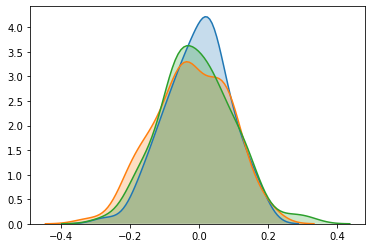

In [8]:
for c in ('disk', 'bulge', 'bar'):
  diff = df['original-{}-mean'.format(c)] -  df['validation-{}-mean'.format(c)]
  sns.kdeplot(diff, shade=True)
  print(c, diff.mean(), diff.std())

## The aggregate model

How consistent is our aggregated model? We explore the consistency with which a component appears in our aggregated model, and how frequently we obtain a consistent number of spiral arms.

In [9]:
# gzb_models = pd.read_pickle('lib/aggregation_results.pickle')
gzb_models = pd.read_pickle('lib/models.pickle')

In [10]:
disks = gzb_models['aggregate'].apply(pd.Series).disk.apply(pd.Series)
bulges = gzb_models['aggregate'].apply(pd.Series).bulge.apply(pd.Series)
bars = gzb_models['aggregate'].apply(pd.Series).bar.apply(pd.Series)
spirals = gzb_models['aggregate'].apply(pd.Series).spiral

In [11]:
original_models = gzb_models.loc[ss_ids]
validation_models = gzb_models.loc[validation_ids]
disk_agree = ~np.logical_xor(
    disks['Re'].loc[ss_ids].notna().values,
    disks['Re'].loc[validation_ids].notna().values
)
bulge_agree = ~np.logical_xor(
    bulges['Re'].loc[ss_ids].notna().values,
    bulges['Re'].loc[validation_ids].notna().values
)
bar_agree = ~np.logical_xor(
    bars['Re'].loc[ss_ids].notna().values,
    bars['Re'].loc[validation_ids].notna().values
)
print('Disk agrees {:.3%} of the time'.format(disk_agree.sum() / len(disk_agree)))
print('Bulge agrees {:.3%} of the time'.format(bulge_agree.sum() / len(disk_agree)))
print('Bar agrees {:.3%} of the time'.format(bar_agree.sum() / len(disk_agree)))
print('Total model agrees {:.3%} of the time'.format(
    (disk_agree & bulge_agree & bar_agree).sum() / len(disk_agree)
))

Disk agrees 95.918% of the time
Bulge agrees 87.755% of the time
Bar agrees 64.286% of the time
Total model agrees 54.082% of the time


In [12]:
def get_n_spirals_in_model(sid):
    return len([
        f for f in os.listdir('lib/spiral_arms')
        if re.match(r'{}-[0-9]+\.pickle'.format(sid), f)
    ])
n_spirals_original = spirals.apply(len).loc[ss_ids]
n_spirals_validation = spirals.apply(len).loc[validation_ids]

n_spirals_agree = n_spirals_original == n_spirals_validation.values
n_spirals_within_1 = np.abs(n_spirals_original - n_spirals_validation.values) < 2
print('N_spirals agree {:03.2%} of the time'.format(
    n_spirals_agree.sum() / len(n_spirals_agree)
))
print('N_spirals within 1 {:03.2%} of the time'.format(
    n_spirals_within_1.sum() / len(n_spirals_within_1)
))

N_spirals agree 63.27% of the time
N_spirals within 1 93.88% of the time


How consistent are the isophotes for our aggregated shapes?

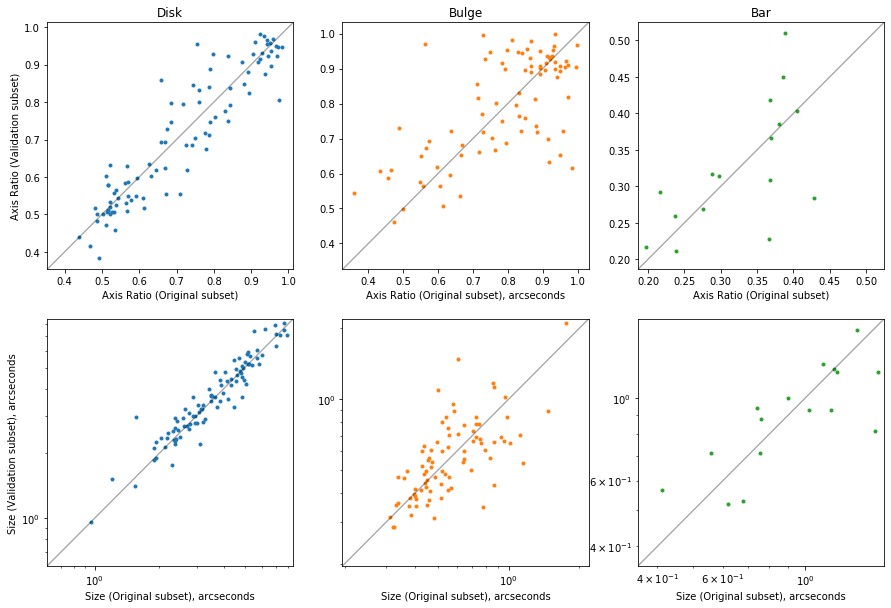

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax_disk, ax_bulge, ax_bar = np.array(axes).T
# Disk
ax = ax_disk
ax[0].plot(
    disks['q'].loc[ss_ids].values,
    disks['q'].loc[validation_ids].values,
    '.', c='C0',
)
ax[1].plot(
    disks['Re'].loc[ss_ids].values * 0.396,
    disks['Re'].loc[validation_ids].values * 0.396,
    '.', c='C0',
)
ax[0].set_title('Disk')
# ax[1].set_title('Disk size')

ax[0].set_xlabel('Axis Ratio (Original subset)')
ax[1].set_xlabel('Size (Original subset), arcseconds')
ax[0].set_ylabel('Axis Ratio (Validation subset)')
ax[1].set_ylabel('Size (Validation subset), arcseconds')

# Bulge
ax = ax_bulge
ax[0].plot(
    bulges['q'].loc[ss_ids].values,
    bulges['q'].loc[validation_ids].values,
    '.', c='C1',
)
ax[1].plot(
    bulges['Re'].loc[ss_ids].values * 0.396,
    bulges['Re'].loc[validation_ids].values * 0.396,
    '.', c='C1',
)
ax[0].set_title('Bulge')
# ax[1].set_title('Bulge size')
ax[0].set_xlabel('Axis Ratio (Original subset), arcseconds')
ax[1].set_xlabel('Size (Original subset), arcseconds')


# Bar
ax = ax_bar
ax[0].plot(
    bars['q'].loc[ss_ids].values,
    bars['q'].loc[validation_ids].values,
    '.', c='C2',
)
ax[1].plot(
    bars['Re'].loc[ss_ids].values * 0.396,
    bars['Re'].loc[validation_ids].values * 0.396,
    '.', c='C2',
)
ax[0].set_title('Bar')
# ax[1].set_title('Bar')

ax[0].set_xlabel('Axis Ratio (Original subset)')
ax[1].set_xlabel('Size (Original subset), arcseconds')
import matplotlib.ticker as mticker
for ax in (ax_disk, ax_bulge, ax_bar):
    for a in ax:
        l = a.get_xlim() + a.get_ylim()
        lims = min(l), max(l)
        a.add_line(plt.Line2D((-1e3, 1e3), (-1e3, 1e3), c='k', alpha=0.2))
        a.plot((-1e3, 1e3), (-1e3, 1e3), 'k', alpha=0.2, linewidth=1)
        a.set_xlim(lims); a.set_ylim(lims)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
plt.savefig('method-paper-plots/component_sizing.pdf', bbox_inches='tight')

      disc Re     : IQR=1.2088, STD=1.2782
      disc q      : IQR=0.0718, STD=0.0654
     bulge Re     : IQR=0.4859, STD=0.5617
     bulge q      : IQR=0.1546, STD=0.1257
       bar Re     : IQR=0.5950, STD=0.6149
       bar q      : IQR=0.0467, STD=0.0702


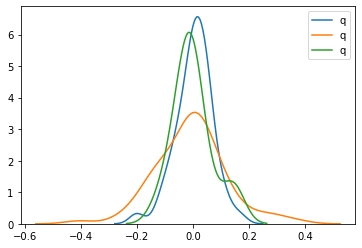

In [14]:
for name, comp in zip(('disc', 'bulge', 'bar'), (disks, bulges, bars)):
  for param in ('Re', 'q'):
    diff = (
      comp[param].loc[ss_ids].reset_index(drop=True)
      - comp[param].loc[validation_ids].reset_index(drop=True)
    )
    print('{: >10} {: <7}: IQR={:.4f}, STD={:.4f}'.format(
      name, param, st.iqr(diff.dropna()), diff.std()
    ))
  sns.kdeplot((
    comp['q'].loc[ss_ids].reset_index(drop=True)
    - comp['q'].loc[validation_ids].reset_index(drop=True)
  ).dropna())